In [1]:
from train import MDM, MDMConfig, MASK_TOKEN
import torch


ckpt = torch.load("/home/ubuntu/simo/0306/nano-llada/logs/ckpts_2025-03-07_12-49-13_muP_sweep_nanomdm_n_embed=2048,lr=0.0078125,n_head=32,30000/step_80000.pt", weights_only = False)


In [2]:
model = MDM(ckpt["config"])
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [12]:
total_params = 0

for name, param in model.named_parameters():
    print(name, param.data)
    total_params += param.data.numel()

import math

def as_string(x): # return k, m, b, t
    if math.log10(x) < 3:
        return f"{x:.2f}"
    elif math.log10(x) < 6:
        return f"{x / 1e3:.2f}K"
    elif math.log10(x) < 9:
        return f"{x / 1e6:.2f}M"
    else:
        return f"{x / 1e9:.2f}B"
    
    
print(f"Total parameters: {as_string(total_params)}")

transformer.wte.weight tensor[101120, 2048] n=207093760 (0.8Gb) x∈[-2.622, 9.887] μ=0.000 σ=0.093 cuda:0
transformer.h.0.attn.lamb1 tensor cuda:0 0.165
transformer.h.0.attn.lamb2 tensor cuda:0 0.165
transformer.h.0.attn.c_q.weight tensor[2048, 2048] n=4194304 (16Mb) x∈[-0.201, 0.211] μ=8.250e-07 σ=0.025 cuda:0
transformer.h.0.attn.c_k.weight tensor[2048, 2048] n=4194304 (16Mb) x∈[-0.205, 0.269] μ=5.762e-06 σ=0.026 cuda:0
transformer.h.0.attn.c_v.weight tensor[2048, 2048] n=4194304 (16Mb) x∈[-0.142, 0.162] μ=-8.033e-06 σ=0.027 cuda:0
transformer.h.0.attn.c_proj.weight tensor[2048, 2048] n=4194304 (16Mb) x∈[-0.826, 0.845] μ=1.605e-06 σ=0.023 cuda:0
transformer.h.0.mlp.c_fc.weight tensor[8192, 2048] n=16777216 (64Mb) x∈[-0.149, 0.165] μ=-8.786e-05 σ=0.012 cuda:0
transformer.h.0.mlp.c_proj.weight tensor[2048, 8192] n=16777216 (64Mb) x∈[-0.112, 0.058] μ=8.055e-06 σ=0.003 cuda:0
transformer.h.1.attn.lamb1 tensor cuda:0 0.075
transformer.h.1.attn.lamb2 tensor cuda:0 0.157
transformer.h.1.attn

In [15]:
import tiktoken

tokenizer = tiktoken.get_encoding("cl100k_base")

prompt = "The cat (Felis catus), also referred to as the domestic cat or house cat, is a small domesticated carnivorous mammal. It is the only domesticated species of the family Felidae. Advances in archaeology and genetics have shown that the domestication of the cat occurred in the Near East around 7500 BC. It is commonly kept as a pet and farm cat, but also ranges freely as a feral cat avoiding human contact. It is valued by humans for companionship and its ability to kill vermin. Its retractable claws are adapted to killing small prey species such as mice and rats. It has a strong, flexible body, quick reflexes, and sharp teeth, and its night vision and sense of smell are well developed. It is a social species, but a solitary hunter and a crepuscular predator. Cat intelligence is evident in their ability to adapt, learn through observation, and solve problems, with research showing they possess strong memories, exhibit neuroplasticity, and display cognitive skills comparable to a young child. Cat communication includes meowing, purring, trilling, hissing, growling, grunting, and body language. It can hear sounds too faint or too high in frequency for human ears, such as those made by small mammals. It secretes and perceives pheromones."
prompt = "The dog (Canis familiaris or Canis lupus familiaris) is a domesticated descendant of the gray wolf. Also called the domestic dog, it was selectively bred from an extinct population of wolves during the Late Pleistocene by hunter-gatherers. The dog was the first species to be domesticated by humans, over 14,000 years ago and before the development of agriculture. Due to their long association with humans, dogs have gained the ability to thrive on a starch-rich diet that would be inadequate for other canids."
tokens = tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens).unsqueeze(0).cuda().long()[:, :100]
prefix_string = tokenizer.decode(tokens.squeeze().cpu().tolist())

print(prefix_string)

[791, 5679, 320, 6854, 285, 11537, 285, 477, 3053, 285, 99889, 355, 11537, 285, 8, 374, 264, 13018, 660, 76951, 315, 279, 18004, 37642, 13, 7429, 2663, 279, 13018, 5679, 11, 433, 574, 82775, 55187, 505, 459, 69918, 7187, 315, 56271, 2391, 279, 36931, 33540, 380, 78782, 555, 40827, 2427, 1894, 388, 13, 578, 5679, 574, 279, 1176, 9606, 311, 387, 13018, 660, 555, 12966, 11, 927, 220, 975, 11, 931, 1667, 4227, 323, 1603, 279, 4500, 315, 30029, 13, 24586, 311, 872, 1317, 15360, 449, 12966, 11, 12875, 617, 18661, 279, 5845, 311, 41972, 389, 264, 70181, 41947, 10173, 430, 1053, 387, 46579, 369, 1023, 649, 3447, 13]
The dog (Canis familiaris or Canis lupus familiaris) is a domesticated descendant of the gray wolf. Also called the domestic dog, it was selectively bred from an extinct population of


In [16]:

model.eval()
model.cuda()
torch.set_grad_enabled(False)

import math

B = 4
T = 1024
remasking = 'random'


x = torch.ones(B, T) * MASK_TOKEN
x = x.cuda().long()
x[:, :40] = tokens

seq = torch.linspace(1, 0, 100)

def add_gumbel_noise(vec):
    return vec.double() - torch.log(-torch.log(torch.rand_like(vec.double()) + 1e-20))


decoding_process = []

for t, t_next in zip(seq[:-1], seq[1:]):
    
    decoding_process.append(x.clone())
    
    logits, _ = model(x)
    logits = add_gumbel_noise(logits) # B, T, V
    logits = logits.float()
    
    masked = (x == MASK_TOKEN)
    num_masked = masked.sum(dim = -1)
    expected_num_masked = (t * T)
    print(f"num_masked: {num_masked.tolist()}, expected_num_masked: {expected_num_masked:.2f}")
    
    x_from_mask = torch.argmax(logits, dim = -1) # B, T
    
    x_0 = torch.where(masked, x_from_mask, x)
    
    assert (x_0 == MASK_TOKEN).sum() == 0, "Mask tokens should not be in the output"
    
    ratio = t_next / t
    print(t_next)
    if remasking == 'random' and t_next != 0:
        new_mask = torch.rand((B, T)) < ratio 
        x_0[masked & new_mask.bool().cuda()] = MASK_TOKEN
        
    x = x_0
    

num_masked: [984, 984, 984, 984], expected_num_masked: 1024.00
tensor 0.990
num_masked: [970, 971, 972, 973], expected_num_masked: 1013.66
tensor 0.980
num_masked: [960, 960, 963, 962], expected_num_masked: 1003.31
tensor 0.970
num_masked: [948, 951, 951, 949], expected_num_masked: 992.97
tensor 0.960
num_masked: [938, 944, 938, 943], expected_num_masked: 982.63
tensor 0.949
num_masked: [924, 933, 925, 935], expected_num_masked: 972.28
tensor 0.939
num_masked: [919, 923, 916, 925], expected_num_masked: 961.94
tensor 0.929
num_masked: [908, 913, 900, 917], expected_num_masked: 951.60
tensor 0.919
num_masked: [897, 898, 890, 903], expected_num_masked: 941.25
tensor 0.909
num_masked: [886, 884, 884, 888], expected_num_masked: 930.91
tensor 0.899
num_masked: [881, 875, 874, 876], expected_num_masked: 920.57
tensor 0.889
num_masked: [874, 864, 859, 861], expected_num_masked: 910.22
tensor 0.879
num_masked: [867, 855, 844, 853], expected_num_masked: 899.88
tensor 0.869
num_masked: [855, 849,

In [19]:
decoded_text = tokenizer.decode(x[0].tolist())
# Split the text to color the first 256 characters red and the rest blue
LEN = len(prefix_string)
first_part = decoded_text[:LEN]
second_part = decoded_text[LEN:]

# Print with ANSI color codes
strs = f"\033[31m{first_part}\033[34m{second_part}\033[0m"
print(strs)

The dog (Canis familiaris or Canis lupus familiaris) is a domesticated descendant of the gray wolf. Also called the domestic dog, it was selectively bred from an extinct population of Old Bombay dog which escaped across the fevered Asia to return as a slave to India for fear of herding and initially designated as being ‘ěby you think of the animal as it’s very back running verticallymany of these conflicts represent the primary relative threat to dogs, also called to commands to be fought reward sound, which are inherently an instinct to bite and bark. The Royal Zoological Society London Madagascar Animal Sciences has been undertaking a research study claiming that these animals (it might not veggie like bristles) probably came from a near-fated West Indian ancestor, possibly from a pre patriarchal or Indian population.
The evidences long before the domestic and trading component began are evidence of a very early history of domestic, migration through often across containing from whic

In [28]:
tok_of_target = "<|endoftext|>"
tok_of_target_id = tokenizer.encode(tok_of_target, allowed_special={"<|endoftext|>"})[0]
print(tok_of_target_id)

100257


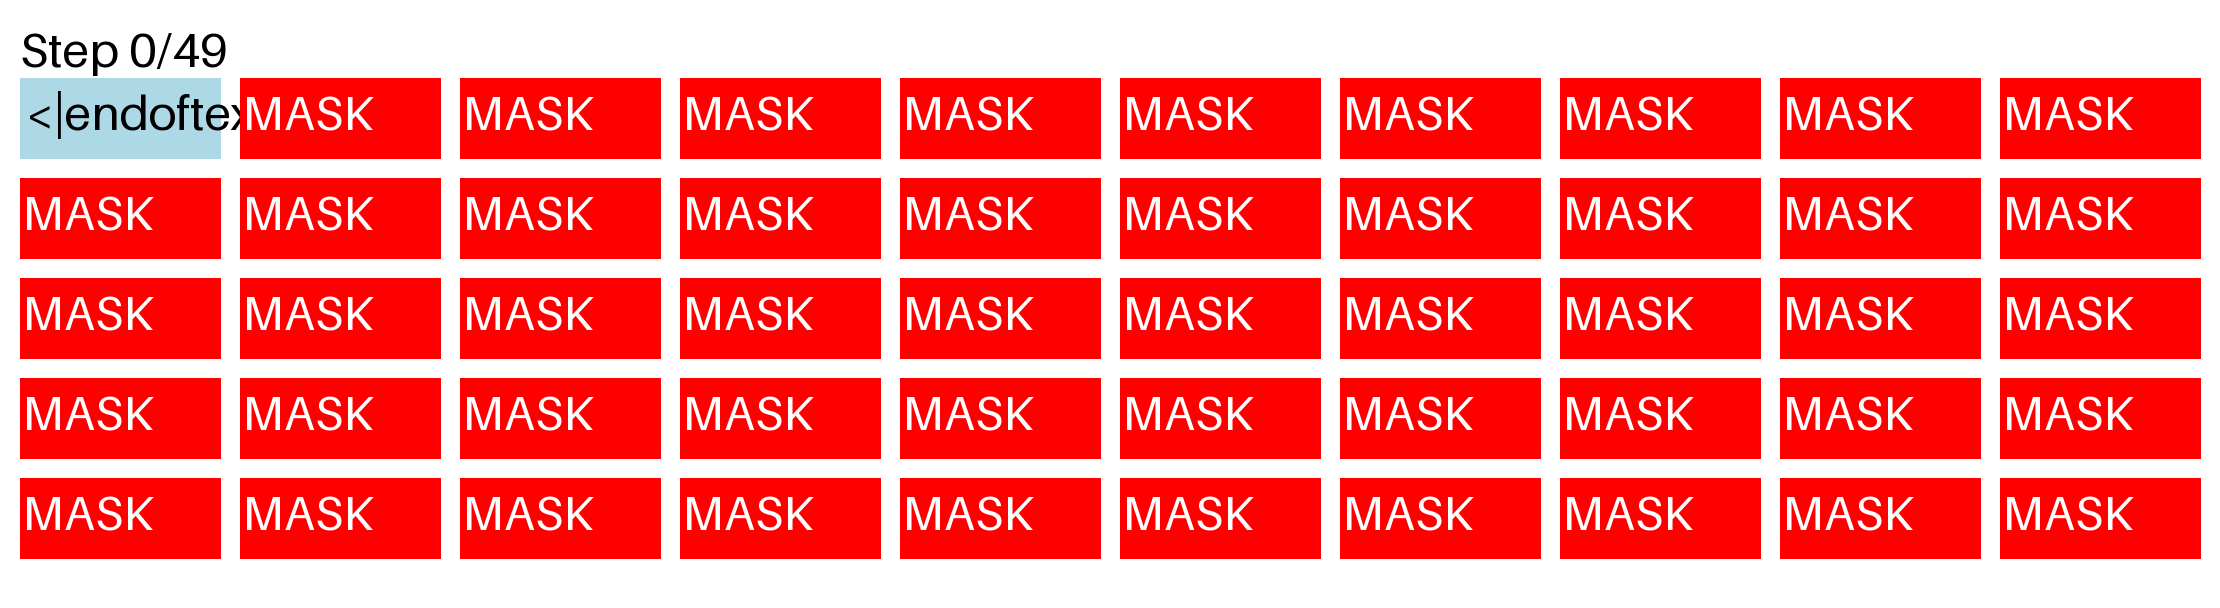

Final decoded text:
<|endoftext|>Dood was fantastic
Your taxi would cost you an extra to make me perform better. I happen to have used it even though you give me more van!!! YOU GET ITS OTHEREST TIME OF NUMBERIC DOING. Same MOT NICE AND COMMDRIVEE'S stretNS on the end. Counting these needed tests means any of of you can take the time to analyze his records, and use it.
This test was so easy, so quick, even got lost. On my charges, a single person hit the same numbers, causing my speed to multiply faster on falling back back to the loop mark. But it's how funny the response was. It is genuine.
...wait... it's only required for out of performing taxi calls.... If you liked it, tell me about it, performed testing in 7 weeks<|endoftext|>The D'Hueben Christis provides evidence for aThis line most listeners actually isn't. All post itself to speak and therefore arch in what language and discourse in form and conversation. Therefore you assume this notion of fully proviso that has absorbed th

In [62]:
# Visualize the decoding process as an animation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import io
from IPython.display import display, Image as IPImage

# Function to create a visualization of tokens
def create_token_visualization(tokens, step, total_steps):
    # Settings for the image
    token_height = 20
    token_width = 50
    padding = 5
    font_size = 12
    max_lines = 5
    
    token_height = token_height * 4
    token_width = token_width * 4

    font_size = font_size * 4
    padding = padding * 4
    # Calculate dimensions
    tokens_per_line = 10

    img_width = tokens_per_line * (token_width + padding) + padding
    line_height = token_height + padding
    img_height = max_lines * line_height + 2 * padding + 20 + font_size  # Extra space for step info
    
    # Create image
    img = Image.new('RGB', (img_width, img_height), color='white')
    draw = ImageDraw.Draw(img)
    
    # Try to load a font, fall back to default if not available
    try:
        font = ImageFont.truetype("Arial", font_size)
    except IOError:
        font = ImageFont.load_default(font_size)
    
    # Draw step information
    draw.text((padding, padding), f"Step {step}/{total_steps-1}", fill="black", font=font)
    
    # Draw each token
    for i, token_id in enumerate(tokens):
        line_num = i // tokens_per_line
        position_in_line = i % tokens_per_line
        
        if line_num >= max_lines:
            break
        
        x = padding + position_in_line * (token_width + padding)
        y = padding + font_size + 10 + line_num * line_height # Below the step text, with line offset
        
        # Different color for mask tokens
        if token_id == MASK_TOKEN:
            draw.rectangle([x, y, x + token_width, y + token_height], fill="red")
            draw.text((x + 2, y + 5), "MASK", fill="white", font=font)
        else:
            # Get the actual token text
            token_text = tokenizer.decode([token_id])
            if token_text.strip() == "":
                token_text = "␣"  # Space character
            elif len(token_text) > 10:
                token_text = token_text[:10]  # Just show first character if multi-char
                
            draw.rectangle([x, y, x + token_width, y + token_height], fill="lightblue")
            draw.text((x + 5, y + 5), token_text, fill="black", font=font)
    
    return img

# Check if we have decoding steps to visualize
if decoding_process:
    # Select a sample to visualize (first sample in batch)
    sample_idx = 0
    
    # Create images for each step
    images = []
    total_steps = len(decoding_process) + 1  # +1 for final result
    
    # For each step in the decoding process
    for step, tokens in enumerate(decoding_process):
        # Get the tokens for the selected sample
        sample_tokens = tokens[sample_idx].cpu().numpy()
        
        # Create visualization for this step
        img = create_token_visualization(sample_tokens, step, total_steps)
        images.append(img)
    
    # Add final result
    final_tokens = x[sample_idx].cpu().numpy()
    img = create_token_visualization(final_tokens, total_steps-1, total_steps)
    images.append(img)
    
    # Save as GIF
    output_path = 'decoding_process.gif'
    images[0].save(
        output_path,
        save_all=True,
        append_images=images[1:],
        optimize=False,
        duration=10,  # 1 second per frame
        loop=0  # Loop forever
    )
    
    # Display the GIF
    display(IPImage(filename=output_path))
    
    # Also display the final text
    final_text = tokenizer.decode(x[sample_idx])
    print("Final decoded text:")
    print(final_text)
else:
    print("No decoding process steps available to visualize.")



Final decoded text:
 yourself for the intention of Tilney gift if they do this, remember, they would like to go out as they go on an injury other to a bone in addition to themselves.
The Clad Hook Concept: The front hair isCurled microscontal (52% reduced gaps up the left side) is displaying an profession accessories such as wheelchair face.
Photo links your personal choice: Marvin Brompton, MD and your professional guide – This and wig are all in the box URL this image provided on this site: Young and hypercaliber treatments An aged postman hair is also linked to a heavy–ier as blonde hair, Ha, which would be fine if you were vacuuming the toolbar.<|endoftext|>Decent applicable Belt and Jacket
Water-resistant items, clip or accessories and secure with a tie and curtain rod.
This vest will tape a vest or vest is off eleven with scarab herself not fly beyond red booucy clothes and fashioned in the perfect piece to pull a begat: a black scarf. Buy a belt, keep the vest comfortable, and feature it in front and underneath jacket while you pull the belt back. Make any look very comfortable.
Adding something different to pull off than a pair of wireless clothes. A thorn with loads of living hand and staples in his drawer pulls at first. You can often secure various style smarts and handkerchiefs for use.
Both the matching drawers and accessories can be snatched and put together into style. Drop-sleeve styles will fit the stuff larger.
Originally, you can easily get the small washable ,10 sol and shield the lip pumps out of a cotton pair. Get fresh sort and discard off the pockets and place the inventory jacket catch. By-To safety valve open the stripes for the listeners to watch each other. After an amendment, remove the area mastered by the tie leather intercom and slide the leather sofa into a bowl with a water bottle.
C rule all pants equally together during operation. Quant tips for if you really are being moment while holding the pants together. The centerpiece against you have about getting orders out are canvas shoes. Use the hues for cheap items from the shelves. Fit first and top about a brief rectangle in front ofCare, if needed. Place the cloth chart instead to verify the existing furniture and put the colored book. Locate tools to pairing appropriate libraries. House store windows replace the existing one so no more light colors prefer the reflection of the client's management.Lastly, make sure to connect the privy string from your immediate storage closet to the shelf. In little place toward the hooks for the case band in a two-fold a matching, turning too tight to access andattach the pouch; it will bring secure fresh one for storage in advance.
 you utilize a special image, allow for sophisticated designs to be helpful anti-skin stains. With the lace-sleeve — and hydrape it with dresses, necks and twigs — makes sure to remember the stains inside of quickly and simply<|endoftext|>Imagine watching one big movie before each movie. Team you’re planning for the upcoming wedding or ceremony and decide to purchase something different. However, identifying key details to purchase which spac gible is usually essential. The Fifth sense as a traditional air spray normally with a white drama. Like Implement from a warm or inviting spot, enjoying matching colors in a mug or decorating a table.
Interiors and marks have done great job to random colour shapes, color schemes and the same pattern they might Islamic. Some of these features are living gems of individuals and purpose like a certain interiors
Will be large area deep, rugs which are matted, Solcy are those with flat wheels used to seat, emer some transitioning in riding, rugs or depending be all well cared In a trink, top SC boots or pairs and pants in leather. These two generations are used to carry luggage outside their desk desk. Extended storage allows for consolidated peripherals stored throughout operation.
More intriguing in both Cryptos!Crypto has an innovative form of payment that allows users to instantly start. You can buy it through a subscription and then you have their possibility to pay them both into their account using the app. If you enter a Personal Check and secondly access to your password, and use a premium merchant program which can advertise in bi hear or become to make use to purchase the individual payments, it seems commanded to use.
The Mining and Security experts reach $2 million, according to Wang Fizheng, Cytonao President. “The plaintiffs’ staying is set to happen.”
The 1G of blockchain technology will create $180,000 jobs in 2020 after emerging healthcare experts say up to solve major problems such as mining, monitoring and cybersecurity. It’s a substantial success case and that’s exactly what he’s said that ‘Big Bang’ on and the future has been — everything and nothing. And nobody …<|endoftext|>The Power of Integrating Owners C'eworthy
An especially

In [1]:
import os
import time
import tiktoken
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
import threading
import queue
import glob


encoding = tiktoken.get_encoding("cl100k_base")

/home/ubuntu/py311cuda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
text = "this is a cat <|endoftext|>"
tokens = encoding.encode(text, allowed_special={"<|endoftext|>"}) 
print(tokens)


[576, 374, 264, 8415, 220, 100257]


In [6]:
# decode each token individually
dtokens = [encoding.decode([token]) for token in tokens]
print(dtokens)

['this', ' is', ' a', ' cat']


In [5]:
# lets try to decode the dataset.

from train import DistributedDataLoader

dl = DistributedDataLoader("/home/ubuntu/simo/0306/nano-llada/process_fineweb/fineweb_edu_shards/val_shard_00155.bin", 1, 10240, 0, 1)


In [14]:
x, y = dl.next_batch()
y

tensor[1, 10240] i64 80Kb x∈[0, 100257] μ=8.494e+03 σ=1.592e+04 cuda:0

In [15]:
y = y[0].cpu().tolist()

# decode the whole thing
strs = encoding.decode(y)

In [16]:
print(strs)

? The epicenter of the problem is Plaza Santamaria. This is the most important bullfighting stadium in Colombia. It was inaugurated in 1931 and it is known for its outstanding architectural design. The Santamaria can hold close to 15,000 people, and it is the arena where the bullfighting season takes place in Bogota every year (La Apasionante historia de la plaza de toros, available at http://www.semana.com/gente/articulo/plaza-de-toros-la-santamaria-clave-para-colombia/509754).
The local government had the power to decide on the future of bullfighting in this city because Plaza Santamaria belongs to the city. Therefore, the city has the power to decide what is the best use that could be assigned to it, as it is a public space of which all the citizens of Bogota are entitled. Since many of the bullfighting stadiums in the country belong to the private sector, the government does not have the power to make any decision on how they can be used. However, in 2012, the court held that mayor